In [1]:
# 季節性の具体例
%matplotlib inline
from scipy.stats import t
import pandas as pd
import pandas_datareader.data as pdr
import numpy as np
end='2016/9/30'
n225 = pdr.DataReader("NIKKEI225",'fred',"1949/5/16",end).dropna()
develop=n225.loc[:'1989/12/31']
reform=n225.loc['1989/12/31':]
year=n225.loc['1989']
years=[x+1950 for x in range(66)]
m=lambda x:x.month
count=[0]*12
alpha=0.1
for i in range(len(years)):
    year=n225.loc[str(years[i])]
    r=year.pct_change().groupby([m])
    tv=r.mean()/r.std()*np.sqrt(r.count())
    t0=t.ppf(1-alpha,len(r)-1)
    for j in range(12):
        if float(tv.iloc[j])>t0:
            count[j]+=1
print(count)

[24, 15, 14, 9, 14, 10, 9, 14, 16, 9, 14, 15]


In [2]:
w=lambda x:x.week
count[0]*5
for i in range(len(years)):
    year=n225.loc[str(years[i])]
    r=year.pct_change().groupby([w])
    tv=r.mean()/r.std()*np.sqrt(r.count())
    t0=t.ppf(1-alpha,len(r)-1)
    for j in range(5):
        if float(tv.iloc[j])>t0:
            count[j]+=1
print(count)

[39, 32, 28, 22, 24, 10, 9, 14, 16, 9, 14, 15]


In [3]:
import pandas_datareader.data as pdr
import numpy as np
start='1971/12/1'
end='2016/8/31'
workpop = pdr.DataReader('LFWA64TTJPM647S','fred',start,end).dropna()
gdp = pdr.DataReader('MKTGDPJPA646NWDB','fred',start,end).dropna()
gdp=gdp.resample('A',loffset='-1d').last().dropna()
fx = pdr.DataReader('DEXJPUS','fred',start,end).dropna()
fx=fx.resample('A',loffset='-1d').last().dropna()
workpop=workpop['1972':].resample('A',loffset='-1d').last().dropna()
gdpjpy=gdp.MKTGDPJPA646NWDB*fx.DEXJPUS
gdpjpy=np.log(gdpjpy).dropna()
workpop=np.log(workpop).dropna()

In [4]:
import statsmodels.api as sm
x=sm.add_constant(workpop)
model=sm.OLS(gdpjpy,x)
results=model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     48.06
Date:                Sun, 02 Dec 2018   Prob (F-statistic):           1.61e-08
Time:                        01:33:28   Log-Likelihood:                -13.000
No. Observations:                  45   AIC:                             30.00
Df Residuals:                      43   BIC:                             33.61
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -90.4719     17.888     

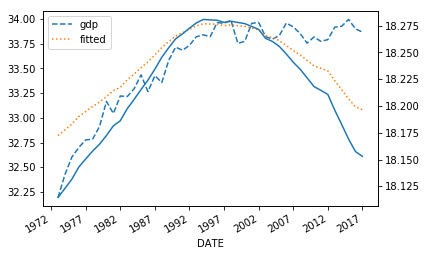

In [5]:
import matplotlib.pyplot as plt
f,ax = plt.subplots()
ax.plot(gdpjpy,label='gdp',linestyle="--")
ax2=ax.twinx()
ax2.plot((workpop),label='workpop')
results.fittedvalues.plot(label='fitted',style=':',ax=ax)
ax.set_ylabel=('log GDP')
ax2.set_ylabel=('workshop')
ax.legend(loc='lower right')
ax.legend(loc='upper left')

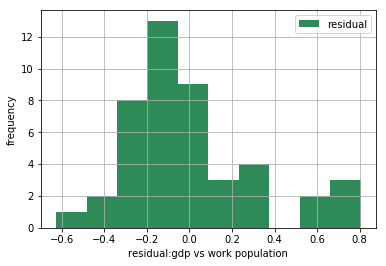

In [6]:
import matplotlib.pyplot as plt
results.resid.hist(label='residual',color='seagreen')
plt.xlabel('residual:gdp vs work population')
plt.ylabel('frequency')
plt.legend(loc='upper right')

In [12]:
import pandas as pd
lnn225 = np.log(pdr.DataReader("NIKKEI225",'fred',start,end).dropna())
lnn225=lnn225.resample('A',loffset='-1d').last().dropna()
port=pd.concat([lnn225,x,gdpjpy],axis=1).dropna()
port.columns=["n225","const","workpop","gdpjpy"]
model=sm.OLS(port.n225,port.ix[0:,['const','workpop','gdpjpy']])
results=model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   n225   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     32.79
Date:                Sun, 02 Dec 2018   Prob (F-statistic):           2.64e-09
Time:                        01:38:06   Log-Likelihood:                -15.469
No. Observations:                  45   AIC:                             36.94
Df Residuals:                      42   BIC:                             42.36
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -79.8766     24.148     -3.308      0.0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


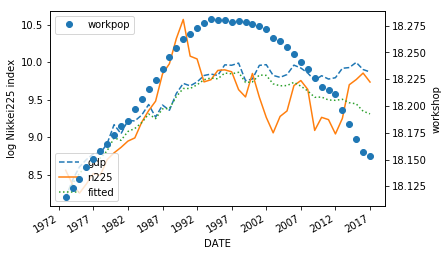

In [13]:
# 多変量解析：折れ線グラフ
f,ax = plt.subplots()
(port.gdpjpy-24).plot(label='gdp',linestyle='--',ax=ax)
port.n225.plot(label='n225',ax=ax)
ax2=ax.twinx()
(port.workpop).plot(label='workpop',ax=ax2,style='o')
results.fittedvalues.plot(label='fitted',style=':',ax=ax)
plt.legend(loc='upper left')
ax.set_ylabel('log Nikkei225 index')
ax2.set_ylabel('workshop')
ax.legend(loc='lower left')
ax2.legend(loc='upper left')

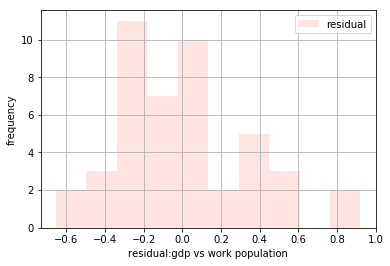

In [15]:
# 多変量解析：ヒストグラム
results.resid.hist(label='residual',color='mistyrose')
plt.xlabel('residual:gdp vs work population')
plt.ylabel('frequency')
plt.legend(loc='upper right')

In [18]:
# バブル崩壊前
port_b=port[:'1990/1/1']
model_b=sm.OLS(port_b.n225,port_b.ix[0:,['const','gdpjpy','workpop']])
results_b=model_b.fit()
print(results_b.summary())

                            OLS Regression Results                            
Dep. Variable:                   n225   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     117.5
Date:                Sun, 02 Dec 2018   Prob (F-statistic):           6.87e-10
Time:                        01:39:26   Log-Likelihood:                 6.7380
No. Observations:                  18   AIC:                            -7.476
Df Residuals:                      15   BIC:                            -4.805
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -381.2246     49.116     -7.762      0.0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


In [19]:
# バブル崩壊後
port_a=port['1990/1/1':]
results_a=(sm.OLS(port_a.n225,port_a.ix[0:,['const','gdpjpy','workpop']])).fit()
print(results_a.summary())

                            OLS Regression Results                            
Dep. Variable:                   n225   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                 -0.039
Method:                 Least Squares   F-statistic:                    0.5135
Date:                Sun, 02 Dec 2018   Prob (F-statistic):              0.605
Time:                        01:39:36   Log-Likelihood:                -5.3726
No. Observations:                  27   AIC:                             16.75
Df Residuals:                      24   BIC:                             20.63
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.1460     39.626     -0.761      0.4

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [31]:
# バブル崩壊後：要素のに
port1_a=port['1990/1/1':]
results1_a=(sm.OLS(port1_a.n225,port1_a.ix[0:,['const','gdpjpy','workpop']])).fit()
print(results1_a.summary())

                            OLS Regression Results                            
Dep. Variable:                   n225   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                 -0.039
Method:                 Least Squares   F-statistic:                    0.5135
Date:                Sun, 02 Dec 2018   Prob (F-statistic):              0.605
Time:                        01:47:37   Log-Likelihood:                -5.3726
No. Observations:                  27   AIC:                             16.75
Df Residuals:                      24   BIC:                             20.63
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.1460     39.626     -0.761      0.4

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
